# DX 704 Week 2 Project

This week's project will analyze fresh strawberry price data for a hypothetical "buy low, freeze, and sell high" business.
Strawberries show strong seasonality in their prices compared to other fruits.

![](https://ers.usda.gov/sites/default/files/_laserfiche/Charts/61401/oct14_finding_plattner_fig01.png)

Image source: https://www.ers.usda.gov/amber-waves/2014/october/seasonal-fresh-fruit-price-patterns-differ-across-commodities-the-case-of-strawberries-and-apples

You are considering a business where you buy strawberries when the prices are very low, carefully freeze them, even more carefully defrost them, and then sell them when the prices are high.
You will forecast strawberry price time series and then use them to tactically pick times to buy, freeze, and sell the strawberries.

The full project description, a template notebook, and raw data are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-02


### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

In [279]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import datetime as datetime
import seaborn as sns
import xgboost as xgb 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


## Part 1: Backtest Strawberry Prices

Read the provided "strawberry-prices.tsv" with data from 2020 through 2024.
This data is based on data from the U.S. Bureau of Statistics, but transformed so the ground truth is not online.
https://fred.stlouisfed.org/series/APU0000711415

Use the data for 2020 through 2023 to predict monthly prices in 2024.
Spend some time to make sure you are happy with your methodology and prediction accuracy, since you will reuse the methodology to forecast 2025 next.
Save the 2024 backtest predictions as "strawberry-backtest.tsv" with columns month and price.

<class 'pandas.DataFrame'>
DatetimeIndex: 60 entries, 2020-01-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


,price
month,
2020-01-01,4.0490
2020-02-01,3.6250
2020-03-01,3.3770
2020-04-01,3.2328
2020-05-01,3.1260


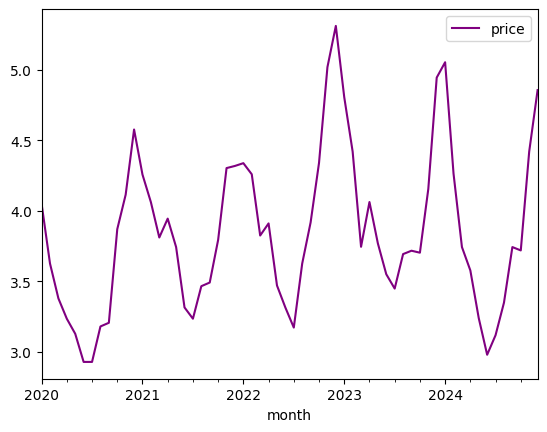

In [280]:
# YOUR CHANGES HERE

df = pd.read_csv("/workspaces/dx704-project-02/strawberry-prices.tsv", sep="\t", )
df = df.set_index('month')
df.index = pd.to_datetime(df.index)

df.info()
df.plot(color='purple')
df.head()

In [281]:
test = df.loc[df.index >= '2024-01-01']
train = df.loc[df.index < '2024-01-01']
#Feature select for month
train['month'] = train.index.month
test['month'] = test.index.month


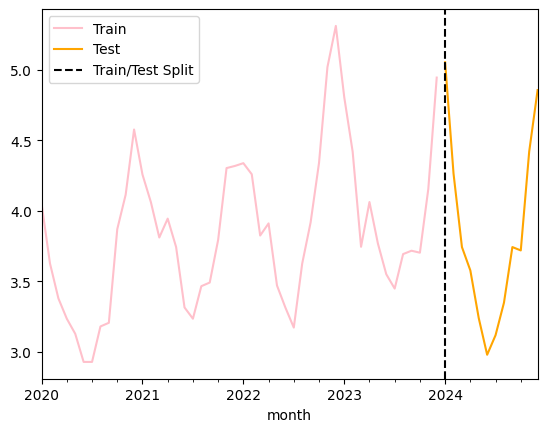

In [282]:
fig, ax = plt.subplots()
train['price'].plot(ax=ax, label='Train', color='pink')
test['price'].plot(ax=ax, label='Test', color='orange')
ax.axvline(pd.to_datetime('2024-01-01'), color='black', linestyle='--', label='Train/Test Split')
ax.legend()
plt.show()

In [283]:
train = train.groupby(train['month']).mean()
train

,price
month,
1,4.362750
2,4.091250
3,3.688750
4,3.787200
5,3.526250
6,3.275000
7,3.194000
8,3.489750
9,3.581750


In [284]:
test['prediction'] = test['month'].map(train['price'])
test

,price,month,prediction
month,,,
2024-01-01,5.055,1,4.362750
2024-02-01,4.264,2,4.091250
2024-03-01,3.742,3,3.688750
2024-04-01,3.576,4,3.787200
2024-05-01,3.237,5,3.526250
2024-06-01,2.977,6,3.275000
2024-07-01,3.116,7,3.194000
2024-08-01,3.347,8,3.489750
2024-09-01,3.742,9,3.581750


In [285]:
backtest = test[['prediction']].copy()
backtest = backtest.rename(columns={'prediction': 'price'})
backtest['month'] = backtest.index
backtest = backtest[['month', 'price']]
backtest = backtest.reset_index(drop=True)
backtest

,month,price
0,2024-01-01,4.362750
1,2024-02-01,4.091250
2,2024-03-01,3.688750
3,2024-04-01,3.787200
4,2024-05-01,3.526250
5,2024-06-01,3.275000
6,2024-07-01,3.194000
7,2024-08-01,3.489750
8,2024-09-01,3.581750
9,2024-10-01,3.926000


In [286]:
backtest.to_csv('strawberry-backtest.tsv', sep='\t', index=False)

Please use the same format for the month column as in the training data, i.e. YYYY-MM-01.
The autograder may not be able to parse other formats.

Submit "strawberry-backtest.tsv" in Gradescope.

## Part 2: Backtest Errors

What are the mean and standard deviation of the residuals between your backtest predictions and the ground truth?

Write the mean and standard deviation to a file "backtest-accuracy.tsv" with two columns, mean and std.

In [287]:
# YOUR CHANGES HERE

strawberry_backtest = pd.read_csv("strawberry-backtest.tsv", sep="\t")
strawberry_backtest.head()

,month,price
0,2024-01-01,4.36275
1,2024-02-01,4.09125
2,2024-03-01,3.68875
3,2024-04-01,3.78720
4,2024-05-01,3.52625


In [288]:
residuals = strawberry_backtest['price'].values - test['price'].values

In [289]:
residuals_mean = residuals.mean()
residuals_std = residuals.std()
print(f"Residuals Mean: {residuals_mean}, Residuals Std Dev: {residuals_std}")


Residuals Mean: 0.004856250000000006, Residuals Std Dev: 0.2628769987491376


In [290]:
accuracy = pd.DataFrame({
    'mean': [residuals_mean],
    'std': [residuals_std]
})
accuracy

,mean,std
0,0.004856,0.262877


In [291]:
accuracy.to_csv('backtest-accuracy.tsv', sep='\t', index=False)

Hint: If the mean residual in your backtest is not close to zero, then your model is likely missing a systematic change and you should go back to improve it.

Submit "backtest-accuracy.tsv" in Gradescope.

## Part 3: Forecast Strawberry Prices

Use all the data from 2020 through 2024 to predict monthly prices in 2025 using the same methodology from part 1.
Make a monthly forecast for each month of 2025 and save it as "strawberry-forecast.tsv" with columns for month and price.


In [292]:
df = pd.read_csv("/workspaces/dx704-project-02/strawberry-prices.tsv", sep="\t")
df = df.set_index('month')
df.index = pd.to_datetime(df.index)

df.head()

,price
month,
2020-01-01,4.0490
2020-02-01,3.6250
2020-03-01,3.3770
2020-04-01,3.2328
2020-05-01,3.1260


In [293]:
train_forecast = df.copy()
#Feature select for month
train_forecast['month'] = train_forecast.index.month

In [294]:
train_means= train_forecast.groupby(train_forecast['month']).mean()
train_means

,price
month,
1,4.50120
2,4.12580
3,3.69940
4,3.74496
5,3.46840
6,3.21540
7,3.17840
8,3.46120
9,3.61380


In [295]:
forecast_2025 = pd.DataFrame(
    index=pd.date_range(start='2025-01-01', end='2025-12-01', freq='MS')
)
forecast_2025['month'] = forecast_2025.index.month

In [296]:
forecast_2025['price'] = forecast_2025['month'].map(train_means['price'])

In [297]:
forecast_2025 = forecast_2025.reset_index()
forecast_2025 = forecast_2025.drop(columns=['month']) #?????
forecast_2025 = forecast_2025.rename(columns={'index': 'month'})
forecast_2025 = forecast_2025[['month', 'price']]
forecast_2025

,month,price
0,2025-01-01,4.50120
1,2025-02-01,4.12580
2,2025-03-01,3.69940
3,2025-04-01,3.74496
4,2025-05-01,3.46840
5,2025-06-01,3.21540
6,2025-07-01,3.17840
7,2025-08-01,3.46120
8,2025-09-01,3.61380
9,2025-10-01,3.88440


In [298]:
forecast_2025.to_csv('strawberry-forecast.tsv', sep='\t', index=False)

Submit "strawberry-forecast.tsv" in Gradescope.

## Part 4: Buy Low, Freeze and Sell High

Using your 2025 forecast, analyze the profit picking different pairs of months to buy and sell strawberries.
Maximize your profit assuming that it costs &dollar;0.20 per pint to freeze the strawberries, &dollar;0.10 per pint per month to store the frozen strawberries and there is a 10% price discount from selling previously frozen strawberries.
So, if you buy a pint of strawberies for &dollar;1, freeze them, and sell them for &dollar;2 three months after buying them, then the profit is &dollar;2 * 0.9 - &dollar;1 - &dollar;0.20 - &dollar;0.10 * 3 = &dollar;0.30 per pint.
To evaluate a given pair of months, assume that you can invest &dollar;1,000,000 to cover all costs, and that you buy as many pints of strawberries as possible.

Write the results of your analysis to a file "timings.tsv" with columns for the buy_month, sell_month, pints_purchased, and expected_profit.

In [299]:
strawberry_forecast = pd.read_csv("strawberry-forecast.tsv", sep="\t")
strawberry_forecast = strawberry_forecast.set_index('month')
strawberry_forecast.info()
strawberry_forecast.index = pd.to_datetime(strawberry_forecast.index)
strawberry_forecast

<class 'pandas.DataFrame'>
Index: 12 entries, 2025-01-01 to 2025-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   12 non-null     float64
dtypes: float64(1)
memory usage: 192.0+ bytes


,price
month,
2025-01-01,4.50120
2025-02-01,4.12580
2025-03-01,3.69940
2025-04-01,3.74496
2025-05-01,3.46840
2025-06-01,3.21540
2025-07-01,3.17840
2025-08-01,3.46120
2025-09-01,3.61380


Using your 2025 forecast, analyze the profit picking different pairs of months to buy and sell strawberries.

Maximize your profit assuming that it costs &dollar;0.20 per pint to freeze the strawberries, &dollar;0.10 per pint per month to store the frozen strawberries and there is a 10% price discount from selling previously frozen strawberries.

So, if you buy a pint of strawberies for &dollar;1, freeze them, and sell them for &dollar;2 three months after buying them, then the profit is &dollar;2 * 0.9 - &dollar;1 - &dollar;0.20 - &dollar;0.10 * 3 = &dollar;0.30 per pint.

To evaluate a given pair of months, assume that you can invest &dollar;1,000,000 to cover all costs, and that you buy as many pints of strawberries as possible.

Write the results of your analysis to a file "timings.tsv" with columns for the buy_month, sell_month, pints_purchased, and expected_profit.

In [300]:

BUDGET = 1_000_000
FREEZE_COST = 0.20
STORAGE_COST_PER_MONTH = 0.10
SELL_DISCOUNT = 0.10  # 10%
months_stored = 3  # From May to August
buy_price = 2.1 # forecast price in buy month May 2025
sell_price = 3.46120 # forecast price in sell month August 2025

revenue_per_pint = sell_price * 0.9

cost_per_pint = buy_price + 0.20 + 0.10 * months_stored

profit_per_pint = revenue_per_pint - cost_per_pint

# profit_per_pint = sell_price * 0.9 - buy_price - FREEZE_COST - STORAGE_COST_PER_MONTH * months_stored 

pints_purchased = BUDGET // cost_per_pint

pints_purchased * cost_per_pint <= 1_000_000

expected_profit = pints_purchased * profit_per_pint

print(f"Expected Profit: ${expected_profit:,.2f}")


Expected Profit: $198,107.49


In [301]:
# YOUR CHANGES HERE

BUDGET = 1_000_000
FREEZE_COST = 0.20
STORAGE_COST_PER_MONTH = 0.10
SELL_DISCOUNT = 0.10    # 10%
months_stored = 3       # From May to August
buy_price = 2.1         # forecast price in buy month May 2025
sell_price = 3.46120    # forecast price in sell month August 2025


revenue_per_pint = sell_price * 0.9

cost_per_pint = buy_price + FREEZE_COST + STORAGE_COST_PER_MONTH * months_stored

profit_per_pint = revenue_per_pint - cost_per_pint

pints_purchased = int(BUDGET // cost_per_pint)

total_cost = pints_purchased * cost_per_pint

expected_profit = pints_purchased * profit_per_pint

print(f"Expected Profit: ${expected_profit:,.2f}")
print(total_cost <= BUDGET)




Expected Profit: $198,107.49
True


In [302]:
BUDGET = 1_000_000
FREEZE_COST = 0.20
STORAGE_COST_PER_MONTH = 0.10
SELL_DISCOUNT = 0.10    # 10%

rows = []
for buy_month in range(1, 12):
    buy_price = strawberry_forecast.loc[strawberry_forecast.index.month == buy_month, 'price'].values[0]
    
    for sell_month in range(buy_month + 1, 13):
        sell_price = strawberry_forecast.loc[strawberry_forecast.index.month == sell_month, 'price'].values[0]
        months_stored = sell_month - buy_month
        
        revenue_per_pint = sell_price * (1 - SELL_DISCOUNT)
        cost_per_pint = buy_price + FREEZE_COST + STORAGE_COST_PER_MONTH * months_stored
        profit_per_pint = revenue_per_pint - cost_per_pint
        pints_purchased = int(BUDGET // cost_per_pint)
        expected_profit = pints_purchased * profit_per_pint

        
        rows.append([buy_month, sell_month, pints_purchased, expected_profit])
        
timings_df = pd.DataFrame(rows, columns=['buy_month', 'sell_month', 'pints_purchased', 'expected_profit'])
timings_df = timings_df.sort_values("expected_profit", ascending=False)


timings_df

,buy_month,sell_month,pints_purchased,expected_profit
55,7,12,257838,114385.703292
50,6,12,249041,76364.437994
59,8,12,246232,64225.677488
62,9,12,243084,50618.353656
54,7,11,264662,48634.289120
...,...,...,...,...
15,2,7,207219,-407235.067560
7,1,9,181778,-408778.730840
6,1,8,185144,-423261.401280
4,1,6,192263,-443616.110420


In [303]:
timings_df.to_csv('timings.tsv', sep='\t', index=False)

Submit "timings.tsv" in Gradescope.

## Part 5: Strategy Check

What is the best profit scenario according to your previous timing analysis?
How much does that profit change if the sell price is off by one standard deviation from your backtest analysis?
(Variation in the sell price is more dangerous because you can see the buy price before fully committing.)

Write the results to a file "check.tsv" with columns `best_profit` and `one_std_profit`.
To be clear, `one_std_profit` should be the number of pints bought in your best profit scenario times your backtested standard deviation of the residual.
This represents the standard deviation in revenue when selling if you explicitly assume that you buy according to the best profit scenario and your backtest standard deviation is representative of the future prices.

In [304]:
# YOUR CHANGES HERE
profit_scenarios = pd.read_csv("timings.tsv", sep="\t")
backtest_residuals_std = pd.read_csv("backtest-accuracy.tsv", sep="\t")

best_row = profit_scenarios.loc[profit_scenarios["expected_profit"].idxmax()]
#best_row = profit_scenarios.sort_values("expected_profit", ascending=False).head(1)

best_profit = float(best_row["expected_profit"])
best_pints = int(best_row["pints_purchased"])

residual_std = float(backtest_residuals_std["std"].iloc[0])


one_std_profit = best_pints * residual_std

one_std_profit


67779.67960348014

In [305]:
best_profit_scenario = pd.DataFrame([{
    "best_profit": best_profit,
    "one_std_profit": one_std_profit
}])

best_profit_scenario

,best_profit,one_std_profit
0,114385.703292,67779.679603


In [306]:
best_profit_scenario.to_csv("check.tsv", sep="\t", index=False)

best_profit_scenario

,best_profit,one_std_profit
0,114385.703292,67779.679603


Submit "check.tsv" in Gradescope.

## Part 6: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgments are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

In [307]:
text = """None"""

with open("acknowledgements.txt", "w") as f:
    f.write(text)

## Part 7: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.